# P2. Classification on the Walmart Dataset

Task: load the Walmart dataset, write a Support Vector Machine to perform classification over the Month or Season (S1:JAN-FEB-MAR, S2:APR,MAY,JUN, S3:JUL,AUG,SEP, S4:OCT,NOV,DEC) in which a purchase was made, test the network and plot the results for each class.
<!-- ![Walmart](https://raw.githubusercontent.com/Masterx-AI/Project_Retail_Analysis_with_Walmart/main/Wallmart1.jpg) -->


## Task 0: Import libraries ✅

In [118]:
!pip install numpy matplotlib pandas seaborn scikit-learn


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [119]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns; sns.set_theme()
%matplotlib inline

## Task 1: Download/Import Dataset 📃

Link: https://www.kaggle.com/datasets/yasserh/walmart-dataset/input

In [120]:
import os
# Make sure to upload the data in colab
# Importing our dataset
df = pd.read_csv("Walmart.csv")
df.head(5)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


## Task 2: Exploring the data 📃

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [122]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

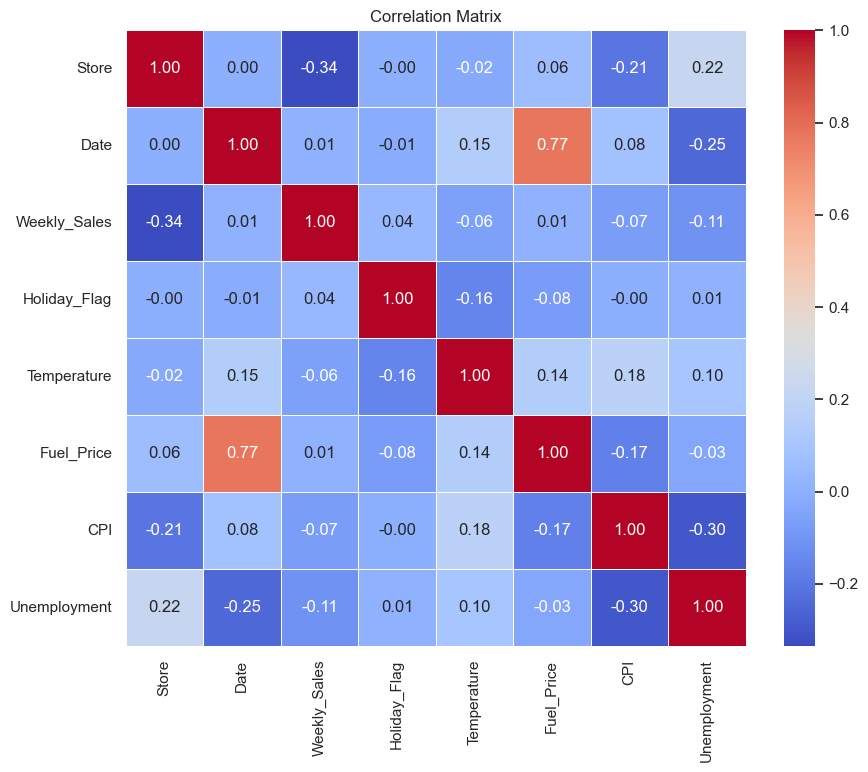

In [157]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Task 3: Preparing the Data 📃
Normalization of the data

In [123]:
from sklearn.model_selection import train_test_split
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

months = df['Date'].dt.month
seasons = (months-1) // 3 + 1

df_nodate = df.drop(columns=['Date'])

df_train, df_test, months_train, months_test, seasons_train, seasons_test = train_test_split(df_nodate, months, seasons, test_size=0.25, random_state=42)

In [124]:
random_indices = np.random.choice(df_train.index, size=5, replace=False)
print(df_train.loc[random_indices])
print(months_train.loc[random_indices])
print(seasons_train.loc[random_indices])

      Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price         CPI  \
6026     43     625196.14             0        88.48       2.653  203.267386   
1948     14    2009004.59             0        59.60       3.570  187.784620   
4444     32    1072474.80             0        50.06       2.776  189.619006   
5856     41    1306644.25             0        59.39       3.659  198.126718   
2499     18    1065214.14             0        64.60       4.034  134.767774   

      Unemployment  
6026         9.593  
1948         8.523  
4444         8.963  
5856         6.432  
2499         8.975  
6026     6
1948    10
4444     4
5856     9
2499     5
Name: Date, dtype: int32
6026    2
1948    4
4444    2
5856    3
2499    2
Name: Date, dtype: int32


## Task 3: Define the SVM 📃

In [146]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

model = SVC(kernel='rbf', class_weight='balanced')
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
grid = GridSearchCV(model, param_grid, refit = True, verbose = 3)


## Task 4: Train 📃

In [147]:
grid.fit(df_train, seasons_train)
model = grid.best_estimator_
print(grid.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ....................C=0.1, gamma=1;, score=0.235 total time=   0.4s
[CV 2/5] END ....................C=0.1, gamma=1;, score=0.279 total time=   0.4s
[CV 3/5] END ....................C=0.1, gamma=1;, score=0.279 total time=   0.4s
[CV 4/5] END ....................C=0.1, gamma=1;, score=0.279 total time=   0.4s
[CV 5/5] END ....................C=0.1, gamma=1;, score=0.279 total time=   0.4s
[CV 1/5] END ..................C=0.1, gamma=0.1;, score=0.235 total time=   0.4s
[CV 2/5] END ..................C=0.1, gamma=0.1;, score=0.279 total time=   0.4s
[CV 3/5] END ..................C=0.1, gamma=0.1;, score=0.279 total time=   0.4s
[CV 4/5] END ..................C=0.1, gamma=0.1;, score=0.279 total time=   0.4s
[CV 5/5] END ..................C=0.1, gamma=0.1;, score=0.279 total time=   0.4s
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.235 total time=   0.4s
[CV 2/5] END .................C=0.1, gamma=0.01

## Task 6: Show results and compare different values of C 📃

              precision    recall  f1-score   support

           1       0.38      0.04      0.07       354
           2       0.33      0.05      0.09       446
           3       0.29      0.93      0.44       454
           4       0.26      0.03      0.05       355

    accuracy                           0.29      1609
   macro avg       0.31      0.26      0.16      1609
weighted avg       0.31      0.29      0.18      1609



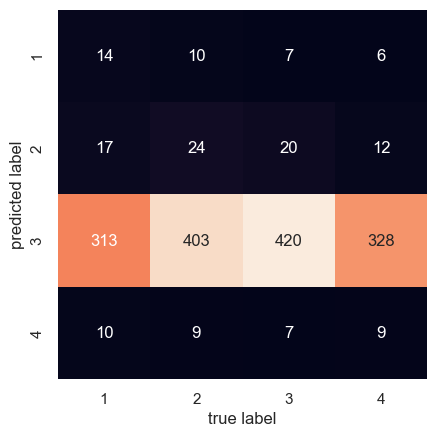

In [148]:
from sklearn.metrics import confusion_matrix
df_fit = model.predict(df_test)
mat = confusion_matrix(seasons_test, df_fit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(seasons_test),
            yticklabels=np.unique(seasons_test))
plt.xlabel('true label')
plt.ylabel('predicted label')

from sklearn.metrics import classification_report
print(classification_report(seasons_test, df_fit))

### Try adding PCA to the model and see if it improves the results

In [179]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(whiten=True,
          svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

param_grid = {'svc__C': [0.1, 1, 10, 100, 1000],
        'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'pca__n_components': [1, 2, 3, 4, 5, 6, 7]}
grid = GridSearchCV(model, param_grid, refit = True, verbose = 3)

In [ ]:
grid.fit(df_train, seasons_train)
model = grid.best_estimator_

# Print the best parameters
print(grid.best_params_)

Fitting 5 folds for each of 175 candidates, totalling 875 fits
[CV 1/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.255 total time=   0.4s
[CV 2/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.267 total time=   0.4s
[CV 3/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.277 total time=   0.4s
[CV 4/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.272 total time=   0.5s
[CV 5/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.274 total time=   0.4s
[CV 1/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.256 total time=   0.4s
[CV 2/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.262 total time=   0.4s
[CV 3/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.295 total time=   0.4s
[CV 4/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.270 total time=   0.4s
[CV 5/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.261 total time=   0.4s
[CV 1/5

{'pca__n_components': 6, 'svc__C': 100, 'svc__gamma': 1}
              precision    recall  f1-score   support

           1       0.75      0.83      0.79       354
           2       0.81      0.75      0.78       446
           3       0.84      0.89      0.86       454
           4       0.81      0.74      0.77       355

    accuracy                           0.80      1609
   macro avg       0.80      0.80      0.80      1609
weighted avg       0.80      0.80      0.80      1609



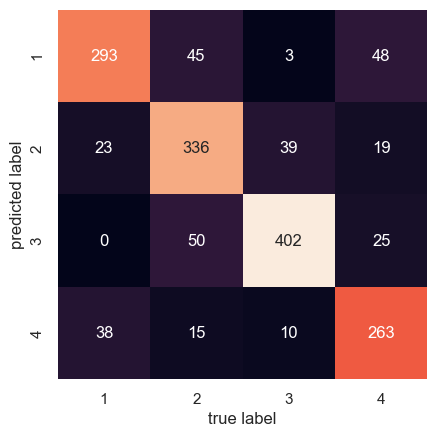

In [ ]:
from sklearn.metrics import confusion_matrix

df_fit = model.predict(df_test)
mat = confusion_matrix(seasons_test, df_fit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(seasons_test),
            yticklabels=np.unique(seasons_test))
plt.xlabel('true label')
plt.ylabel('predicted label')

from sklearn.metrics import classification_report
print(classification_report(seasons_test, df_fit))

### Train also the months

In [186]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(whiten=True,
          svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

param_grid = {'svc__C': [0.1, 1, 10, 100, 1000],
        'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'pca__n_components': [1, 2, 3, 4, 5, 6, 7]}
grid = GridSearchCV(model, param_grid, refit = True, verbose = 3)

In [190]:
grid.fit(df_train, months_train)
model = grid.best_estimator_

# Print the best parameters
print(grid.best_params_)

Fitting 5 folds for each of 175 candidates, totalling 875 fits
[CV 1/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.073 total time=   0.5s
[CV 2/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.074 total time=   0.6s
[CV 3/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.077 total time=   0.5s
[CV 4/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.084 total time=   0.5s
[CV 5/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.088 total time=   0.5s
[CV 1/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.072 total time=   0.5s
[CV 2/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.070 total time=   0.5s
[CV 3/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.079 total time=   0.5s
[CV 4/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.078 total time=   0.5s
[CV 5/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.081 total time=   0.5s
[CV 1/5

              precision    recall  f1-score   support

           1       0.68      0.73      0.71        89
           2       0.46      0.57      0.51       130
           3       0.50      0.56      0.53       135
           4       0.51      0.46      0.48       154
           5       0.53      0.57      0.55       133
           6       0.59      0.58      0.59       159
           7       0.52      0.55      0.53       162
           8       0.47      0.48      0.47       147
           9       0.64      0.63      0.64       145
          10       0.68      0.56      0.61       148
          11       0.56      0.46      0.51        97
          12       0.58      0.54      0.56       110

    accuracy                           0.55      1609
   macro avg       0.56      0.56      0.56      1609
weighted avg       0.56      0.55      0.55      1609



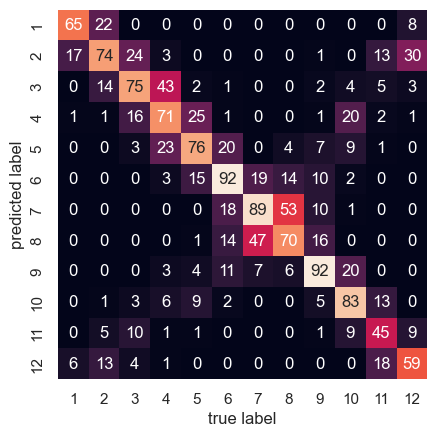

In [192]:
from sklearn.metrics import confusion_matrix

df_fit = model.predict(df_test)
mat = confusion_matrix(months_test, df_fit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(months_test),
            yticklabels=np.unique(months_test))
plt.xlabel('true label')
plt.ylabel('predicted label')

from sklearn.metrics import classification_report
print(classification_report(months_test, df_fit))